In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import colors
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder

In [2]:
from pathlib import Path
my_csv = Path("/home/cefika/Desktop/ip1/marketing_campaign.csv")
data = pd.read_csv(my_csv.resolve(), sep='\t')

In [3]:
inc_med = data['Income'].median()
data['Income'].fillna(inc_med, inplace=True)

data["Age"] = 2021-data["Year_Birth"]

#Total spendings on various items
data["Spent"] = data["MntWines"]+ data["MntFruits"]+ data["MntMeatProducts"]+ data["MntFishProducts"]+ data["MntSweetProducts"]+ data["MntGoldProds"]

#Deriving living situation by marital status"Alone"
data["Living_With"]=data["Marital_Status"].replace({"Married":"Partner", "Together":"Partner", "Absurd":"Alone", "Widow":"Alone", "YOLO":"Alone", "Divorced":"Alone", "Single":"Alone",})

#Feature indicating total children living in the household
data["Children"]=data["Kidhome"]+data["Teenhome"]

#Feature for total members in the householde
data["Family_Size"] = data["Living_With"].replace({"Alone": 1, "Partner":2})+ data["Children"]

#Feature pertaining parenthood
data["Is_Parent"] = np.where(data.Children> 0, 1, 0)

#Segmenting education levels in three groups
data["Education"]=data["Education"].replace({"Basic":"Undergraduate","2n Cycle":"Undergraduate", "Graduation":"Graduate", "Master":"Postgraduate", "PhD":"Postgraduate"})

data['NumTotalPurchases'] = data['NumWebPurchases'] + data['NumCatalogPurchases'] + data['NumStorePurchases'] + data['NumDealsPurchases']
data['Totalacp'] = data['AcceptedCmp1'] + data['AcceptedCmp2'] + data['AcceptedCmp3'] + data['AcceptedCmp4'] + data['AcceptedCmp5'] + data['Response']
data['Totalacp']=np.where(data.Totalacp>0,1,0)
#For clarity
data=data.rename(columns={"MntWines": "Wines","MntFruits":"Fruits","MntMeatProducts":"Meat","MntFishProducts":"Fish","MntSweetProducts":"Sweets","MntGoldProds":"Gold"})

data["Dt_Customer"] = pd.to_datetime(data["Dt_Customer"])
dates = []
for i in data["Dt_Customer"]:
    i = i.date()
    dates.append(i)

#Created a feature "Customer_For"
days = []
d1 = max(dates) #taking it to be the newest customer
for i in dates:
    delta = d1 - i
    days.append(delta)
data["Customer_For"] = days
data["Customer_For"] = pd.to_numeric(data["Customer_For"], errors="coerce")

to_drop = ['Response','Complain',"Marital_Status", "Dt_Customer", "Z_CostContact", "Z_Revenue", "Year_Birth", "ID", 
           "Kidhome", "Teenhome",'AcceptedCmp1',
           'AcceptedCmp2', 'AcceptedCmp3', 'AcceptedCmp4', 'AcceptedCmp5','NumWebPurchases', 'NumCatalogPurchases', 'NumStorePurchases','NumDealsPurchases']
data = data.drop(to_drop, axis=1)
data.reset_index(drop=True,inplace=True)

In [4]:
cols = ["Income","Age"]

for i in cols:
    q1 = data[i].quantile(0.25)
    q3 = data[i].quantile(0.75)
    iqr = q3-q1
    
    outliers = data[(data[i]<(q1-1.5*iqr)) | (data[i]>(q3+1.5*iqr))]
    
    #remove the outliers
    data = data[~((data[i]<(q1-1.5*iqr)) | (data[i]>(q3+1.5*iqr)))]
print("Remaining rows :",len(data))
data.reset_index(drop=True,inplace=True)

Remaining rows : 2229


In [5]:
le = LabelEncoder()
data["Education"] = le.fit_transform(data["Education"])
data["Living_With"] = le.fit_transform(data['Living_With'])
data.dtypes

Education              int64
Income               float64
Recency                int64
Wines                  int64
Fruits                 int64
Meat                   int64
Fish                   int64
Sweets                 int64
Gold                   int64
NumWebVisitsMonth      int64
Age                    int64
Spent                  int64
Living_With            int64
Children               int64
Family_Size            int64
Is_Parent              int64
NumTotalPurchases      int64
Totalacp               int64
Customer_For           int64
dtype: object

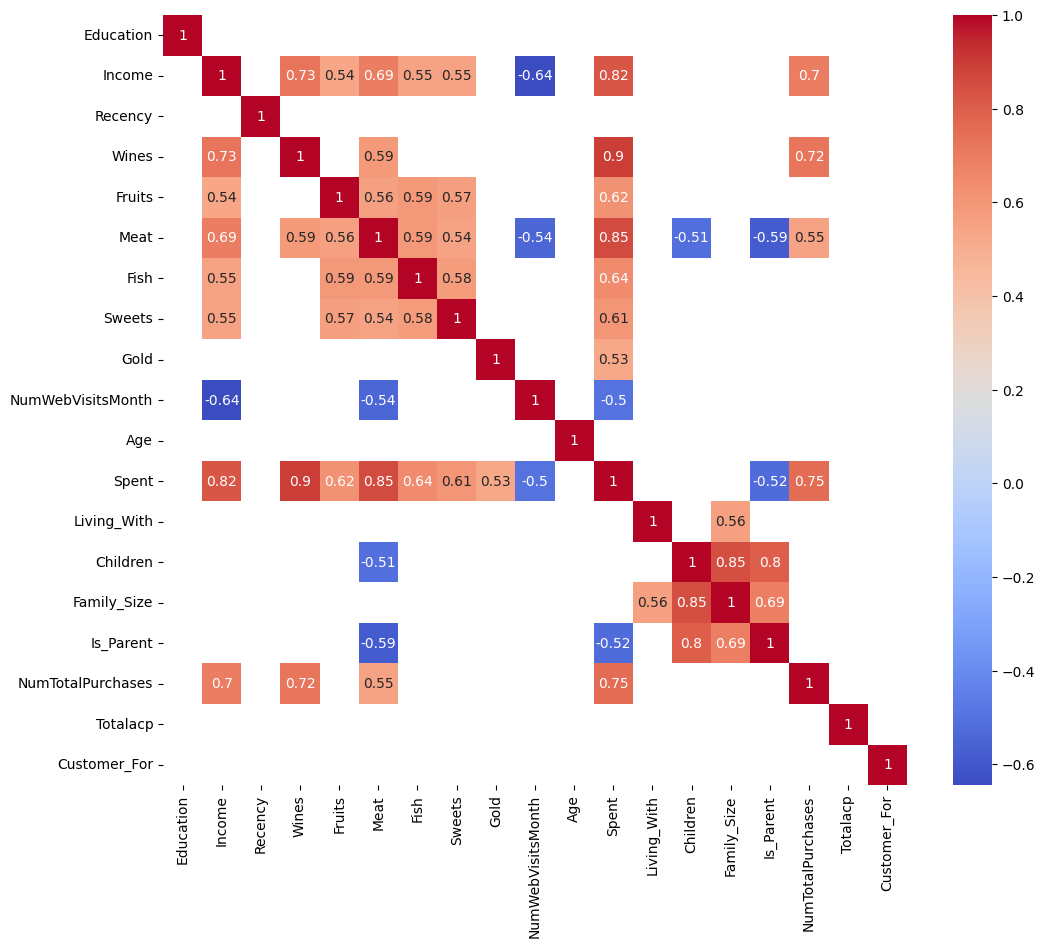

In [6]:
matrica_korelacije = data.corr()

prag = 0.5

korelisani = matrica_korelacije.abs() > prag
korelisani_matrica = matrica_korelacije[korelisani]

plt.figure(figsize=(12, 10))

sns.heatmap(korelisani_matrica, annot=True, cmap='coolwarm')

plt.xticks(rotation=90)
plt.yticks(rotation=0)

plt.show()

,Education,Income,Recency,Wines,Fruits,Meat,Fish,Sweets,Gold,NumWebVisitsMonth,Age,Spent,Living_With,Children,Family_Size,Is_Parent,NumTotalPurchases,Totalacp,Customer_For
0,0,58138.0,58,635,88,546,172,88,88,7,64,1617,0,0,1,0,25,1,83894400000000000
1,0,46344.0,38,11,1,6,2,1,6,5,67,27,0,2,3,1,6,0,10800000000000000
2,0,71613.0,26,426,49,127,111,21,42,4,56,776,1,0,2,0,21,0,40780800000000000
3,0,26646.0,26,11,4,20,10,3,5,6,37,53,1,1,3,1,8,0,5616000000000000
4,1,58293.0,94,173,43,118,46,27,15,5,40,422,1,1,3,1,19,0,27734400000000000


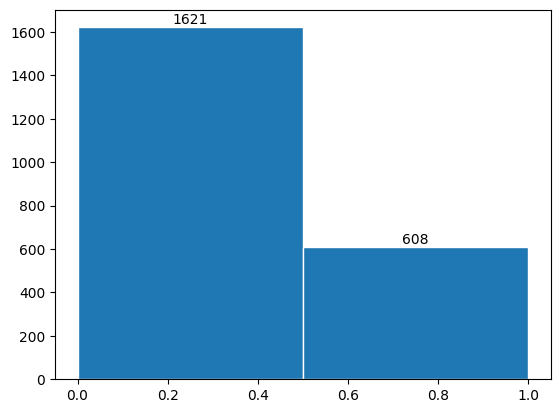

In [7]:
from sklearn.feature_selection import SelectKBest, chi2
X=data.drop(['Totalacp'], axis=1)
y=data['Totalacp']
freq, bins, _ = plt.hist(y, edgecolor='white', bins=2)

bin_centers = np.diff(bins)*0.5 + bins[:-1] # računanje centra korpice

for fr, x in zip(freq, bin_centers):
    height = int(fr)
    plt.annotate("{}".format(height),
               xy = (x, height),             # poziciranje broja iznad korpice
               xytext = (0,0.2),             # odvajanje teksta od korpice
               textcoords = "offset points", 
               ha = 'center', va = 'bottom'
               )

plt.show
data.head()

In [8]:
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import Normalizer, StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=41,stratify=y)

In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [11]:
from sklearn.tree import DecisionTreeClassifier

In [12]:
def model_info(y_real, y_pred):
    print('Confusion matrix: \n', confusion_matrix(y_real, y_pred))
    print('Accuracy score: ', accuracy_score(y_real, y_pred))
    print('Precision score: ', precision_score(y_real, y_pred,average='weighted'))
    print('Recall score: ', recall_score(y_real, y_pred,average='weighted'))
    print('F1 score: ', f1_score(y_real, y_pred,average='weighted'))

def build_model(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    print('Train data:\n')
    y_train_pred = model.predict(X_train)
    model_info(y_train, y_train_pred)
    
    print('\n--------------------------------------\n')

    print('Test data:\n')
    y_pred = model.predict(X_test)
    model_info(y_test, y_pred)
    
    return model

In [13]:
dtc = DecisionTreeClassifier(random_state=51)

In [14]:
dtc = build_model(dtc, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1215    0]
 [   7  449]]
Accuracy score:  0.9958108916816277
Precision score:  0.9958348882104564
Recall score:  0.9958108916816277
F1 score:  0.9958007070742498

--------------------------------------

Test data:

Confusion matrix: 
 [[342  64]
 [ 67  85]]
Accuracy score:  0.7652329749103942
Precision score:  0.7638043941554846
Recall score:  0.7652329749103942
F1 score:  0.7644951261186608


In [15]:
from sklearn.model_selection import GridSearchCV

params = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40, 45],
    #'min_samples_split': [None, 5, 10, 15, 20]
}

In [16]:
estimator = GridSearchCV(DecisionTreeClassifier(random_state=51), param_grid=params, cv=4)
estimator_bal = GridSearchCV(DecisionTreeClassifier(class_weight='balanced'), param_grid=params, cv=4)

In [17]:
estimator.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=51),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40,
                                       45]})

In [18]:
estimator.best_params_

{'criterion': 'gini', 'max_depth': 10}

In [19]:
estimator.best_score_

0.7677962892843619

In [20]:
estimator = build_model(estimator, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1197   18]
 [  73  383]]
Accuracy score:  0.9455415918611609
Precision score:  0.9459560678591623
Recall score:  0.9455415918611609
F1 score:  0.9443967517904562

--------------------------------------

Test data:

Confusion matrix: 
 [[356  50]
 [ 71  81]]
Accuracy score:  0.7831541218637993
Precision score:  0.7750475557403513
Recall score:  0.7831541218637993
F1 score:  0.7778419548221279


In [21]:
estimator_bal.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(class_weight='balanced'),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [None, 5, 10, 15, 20, 25, 30, 35, 40,
                                       45]})

In [22]:
estimator_bal.best_params_

{'criterion': 'gini', 'max_depth': 35}

In [23]:
estimator_bal.best_score_

0.7528340963592761

In [24]:
estimator_bal = build_model(estimator, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1197   18]
 [  73  383]]
Accuracy score:  0.9455415918611609
Precision score:  0.9459560678591623
Recall score:  0.9455415918611609
F1 score:  0.9443967517904562

--------------------------------------

Test data:

Confusion matrix: 
 [[356  50]
 [ 71  81]]
Accuracy score:  0.7831541218637993
Precision score:  0.7750475557403513
Recall score:  0.7831541218637993
F1 score:  0.7778419548221279


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix
from imblearn.combine import SMOTEENN
from termcolor import colored
from sklearn.metrics import classification_report

In [26]:
def report(model, x, y, text = "training"):
    y_pred = model.predict(x)
    
    print(colored("Classification report for model {} on {} data".format(type(model).__name__, text), "green"))
    print("---------------------------------------------------------------------------------")
    print(classification_report(y, y_pred))
    print("---------------------------------------------------------------------------------")

In [27]:
y_train = pd.Categorical(y_train)

# Instantiating a SMOTEENN object
smoteenn = SMOTEENN(sampling_strategy='auto')

# Fiting the SMOTEENN object to the training data
X_train_resampled, Y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# Training the classifier on the resampled data
clf = DecisionTreeClassifier()
clf.fit(X_train_resampled, Y_train_resampled)

report(clf, X_train_resampled, Y_train_resampled)
report(clf, X_test, y_test, "test")

Classification report for model DecisionTreeClassifier on training data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       592
           1       1.00      1.00      1.00       930

    accuracy                           1.00      1522
   macro avg       1.00      1.00      1.00      1522
weighted avg       1.00      1.00      1.00      1522

---------------------------------------------------------------------------------
Classification report for model DecisionTreeClassifier on test data
---------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.87      0.72      0.79       406
           1       0.49      0.72      0.58       152

    accuracy                           0.72       558
   macro avg       0.68      0.72      0.69       558
weighted avg   

In [28]:
from sklearn.ensemble import RandomForestClassifier

In [29]:
random_forest = RandomForestClassifier(random_state=55)

In [30]:
random_forest = build_model(random_forest, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1214    1]
 [   6  450]]
Accuracy score:  0.9958108916816277
Precision score:  0.9958189728841611
Recall score:  0.9958108916816277
F1 score:  0.9958036460091255

--------------------------------------

Test data:

Confusion matrix: 
 [[379  27]
 [ 85  67]]
Accuracy score:  0.7992831541218638
Precision score:  0.7884685045374819
Recall score:  0.7992831541218638
F1 score:  0.782311973657371


In [31]:
params = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [50, 100, 200, 300]
}

estimator_rf = GridSearchCV(RandomForestClassifier(random_state=55), param_grid=params, cv=3)

In [32]:
estimator_rf.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(random_state=55),
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'n_estimators': [50, 100, 200, 300]})

In [33]:
estimator_rf.best_params_

{'criterion': 'entropy', 'n_estimators': 300}

In [34]:
estimator_rf.best_score_

0.81508078994614

In [35]:
estimator_rf = build_model(estimator_rf, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1215    0]
 [   7  449]]
Accuracy score:  0.9958108916816277
Precision score:  0.9958348882104564
Recall score:  0.9958108916816277
F1 score:  0.9958007070742498

--------------------------------------

Test data:

Confusion matrix: 
 [[380  26]
 [ 87  65]]
Accuracy score:  0.7974910394265233
Precision score:  0.7866226778984947
Recall score:  0.7974910394265233
F1 score:  0.7791483034024101


In [36]:
gsss=GradientBoostingClassifier(random_state=55)

In [37]:
gsss = build_model(gsss, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1195   20]
 [ 166  290]]
Accuracy score:  0.8886894075403949
Precision score:  0.8937092397669876
Recall score:  0.8886894075403949
F1 score:  0.8812358552776486

--------------------------------------

Test data:

Confusion matrix: 
 [[378  28]
 [ 86  66]]
Accuracy score:  0.7956989247311828
Precision score:  0.7840025165865935
Recall score:  0.7956989247311828
F1 score:  0.7784246874726812


In [40]:
param_grid_gradient = {
    'learning_rate': [0.1, 0.05, 0.01],
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'min_samples_split': [2, 4, 6]
}

In [43]:
estimator_gsss = GridSearchCV(GradientBoostingClassifier(random_state=55), param_grid=param_grid_gradient, cv=3)

In [48]:
estimator_gsss.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=GradientBoostingClassifier(random_state=55),
             param_grid={'learning_rate': [0.1, 0.05, 0.01],
                         'max_depth': [3, 5, 7], 'min_samples_split': [2, 4, 6],
                         'n_estimators': [100, 200, 300]})

In [49]:
estimator_gsss.best_params_

{'learning_rate': 0.1,
 'max_depth': 7,
 'min_samples_split': 6,
 'n_estimators': 300}

In [50]:
estimator_gsss.best_score_

0.8132854578096947

In [51]:
estimator_gsss = build_model(estimator_gsss, X_train, X_test, y_train, y_test)


Train data:

Confusion matrix: 
 [[1215    0]
 [   7  449]]
Accuracy score:  0.9958108916816277
Precision score:  0.9958348882104564
Recall score:  0.9958108916816277
F1 score:  0.9958007070742498

--------------------------------------

Test data:

Confusion matrix: 
 [[376  30]
 [ 80  72]]
Accuracy score:  0.8028673835125448
Precision score:  0.7922330599849825
Recall score:  0.8028673835125448
F1 score:  0.789181870191531


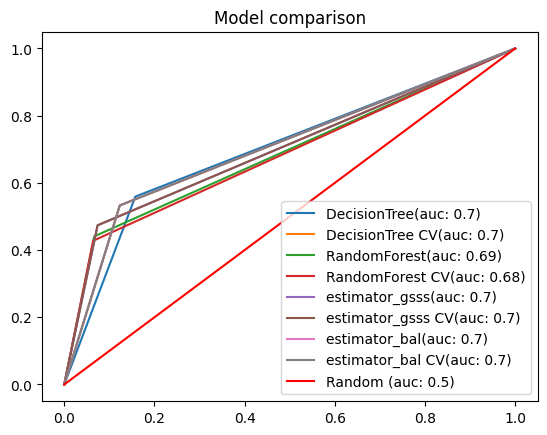

In [53]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [dtc, estimator.best_estimator_, random_forest, estimator_rf.best_estimator_,estimator_gsss,estimator_gsss.best_estimator_,estimator_bal,estimator_bal.best_estimator_]
model_names = ['DecisionTree', 'DecisionTree CV',  'RandomForest', 'RandomForest CV','estimator_gsss','estimator_gsss CV','estimator_bal','estimator_bal CV']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)+0.2
    fpr,tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()

In [54]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

In [55]:
def model_info2(y_real, y_pred):
    print('Confusion matrix: \n', confusion_matrix(y_real, y_pred))
    print('Accuracy score: ', accuracy_score(y_real, y_pred))
    print('Precision score: ', precision_score(y_real, y_pred))
    print('Recall score: ', recall_score(y_real, y_pred))
    print('F1 score: ', f1_score(y_real, y_pred))

def build_model2(model, X_train, X_test, y_train, y_test):
    model.fit(X_train, y_train)

    print('Train data:\n')
    y_train_pred = model.predict(X_train)
    model_info2(y_train, y_train_pred)
    
    print('\n--------------------------------------\n')

    print('Test data:\n')
    y_pred = model.predict(X_test)
    model_info2(y_test, y_pred)

    return model

In [56]:
from sklearn.neighbors import KNeighborsClassifier

In [58]:
knn = KNeighborsClassifier()

In [59]:
knn = build_model2(knn, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1157   58]
 [ 222  234]]
Accuracy score:  0.8324356672651108
Precision score:  0.8013698630136986
Recall score:  0.5131578947368421
F1 score:  0.625668449197861

--------------------------------------

Test data:

Confusion matrix: 
 [[368  38]
 [100  52]]
Accuracy score:  0.7526881720430108
Precision score:  0.5777777777777777
Recall score:  0.34210526315789475
F1 score:  0.4297520661157025


In [60]:
import math
math.ceil(math.sqrt(X_train.shape[0]))

41

In [61]:
from sklearn.model_selection import GridSearchCV

params2 = {
    'n_neighbors': [20 ,25, 30, 35, 40],
    'weights': ['uniform', 'distance'],
    'p': [1, 2]
}

In [62]:
estimator2 = GridSearchCV(KNeighborsClassifier(), param_grid=params2, cv=3)

In [63]:
estimator2.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': [20, 25, 30, 35, 40], 'p': [1, 2],
                         'weights': ['uniform', 'distance']})

In [64]:
estimator2.best_params_

{'n_neighbors': 20, 'p': 1, 'weights': 'distance'}

In [65]:
estimator2.best_score_

0.8061041292639138

In [66]:
estimator2 = build_model2(estimator2, X_train, X_test, y_train, y_test)

Train data:

Confusion matrix: 
 [[1215    0]
 [   7  449]]
Accuracy score:  0.9958108916816277
Precision score:  1.0
Recall score:  0.9846491228070176
F1 score:  0.9922651933701657

--------------------------------------

Test data:

Confusion matrix: 
 [[385  21]
 [ 91  61]]
Accuracy score:  0.7992831541218638
Precision score:  0.7439024390243902
Recall score:  0.40131578947368424
F1 score:  0.5213675213675213


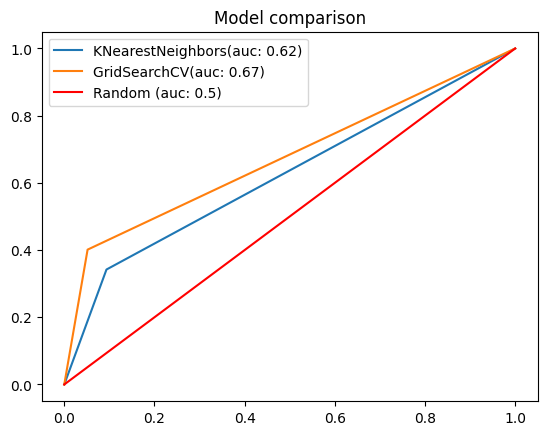

In [74]:
from sklearn.metrics import roc_curve, roc_auc_score
models = [knn, estimator2.best_estimator_]
model_names = ['KNearestNeighbors', 'GridSearchCV']
for model, model_name in zip(models, model_names):
    y_pred = model.predict(X_test)
    fpr,tpr, _ = roc_curve(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred)
    lab = model_name + "(auc: " + str(round(auc, 2)) + ")"
    plt.plot(fpr, tpr, label=lab)

plt.plot([0, 1], [0, 1], label='Random (auc: 0.5)', color='red')
plt.title("Model comparison")
plt.legend()
plt.show()